1. What's the standard procedure
2. Why is this a problem
3. Solution

Misidentifying important variables:

1. Regression coefficients
2. No sense of 'global' or overall importance of each variable
3. G-SHAP on r2 or accuracy

Missing moderators

1. Test interaction between moderator and treatment
2. Doesn't capture non-linear relationships
3. train f(t,m), predict treatment effect as f(1,m)-f(0,m), shap and g-shap values

In [1]:
import gshap
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import bernoulli, norm, uniform

In [2]:
N = 1000
x1 = norm(0, 1).rvs(N)
x2 = norm(0, 2).rvs(N)
X = np.array([x1, x2]).T
y = x1 + x2
reg = LinearRegression().fit(X, y)
print('Coef on x1: {:.2f}'.format(reg.coef_[0]))
print('Coef on x2: {:.2f}'.format(reg.coef_[1]))

Coef on x1: 1.00
Coef on x2: 1.00


In [3]:
X = StandardScaler().fit_transform(X)
reg = LinearRegression().fit(X, y)
print('Coef on x1: {:.2f}'.format(reg.coef_[0]))
print('Coef on x2: {:.2f}'.format(reg.coef_[1]))

Coef on x1: 1.00
Coef on x2: 2.04


<AxesSubplot:ylabel='Count'>

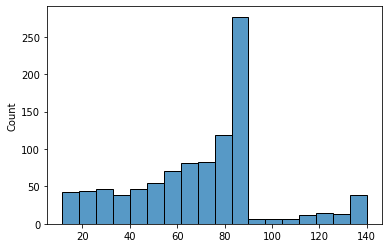

In [6]:
manager = bernoulli(.1).rvs(N)
social = uniform(2, 30).rvs(N)
X = np.array([manager, social, social**2]).T
y = 50 * manager + 6 * social - .1 * social**2
sns.histplot(y)

In [7]:
reg = LinearRegression().fit(X, y)
print('Coef on manager: {:.2f}'.format(reg.coef_[0]))
print('Coef on social: {:.2f}'.format(reg.coef_[1]))
print('Coef on social-squared: {:.2f}'.format(reg.coef_[2]))

Coef on manager: 50.00
Coef on social: 6.00
Coef on social-squared: -0.10


In [8]:
X = StandardScaler().fit_transform(X)
reg = LinearRegression().fit(X, y)
print('Coef on manager: {:.2f}'.format(reg.coef_[0]))
print('Coef on social: {:.2f}'.format(reg.coef_[1]))
print('Coef on social-squared: {:.2f}'.format(reg.coef_[2]))

Coef on manager: 16.01
Coef on social: 51.54
Coef on social-squared: -29.75


In [9]:
class Model(LinearRegression):
    def fit(self, X, y):
        return super().fit(self._transform(X), y)
        
    def predict(self, X):
        return super().predict(self._transform(X))
        
    def _transform(self, X):
        return np.append(X, (X[:,1]**2).reshape(-1, 1), axis=1)
    
X = np.array([manager, social]).T
reg = Model().fit(X, y)
g = lambda y_pred: y_pred
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)

<AxesSubplot:>

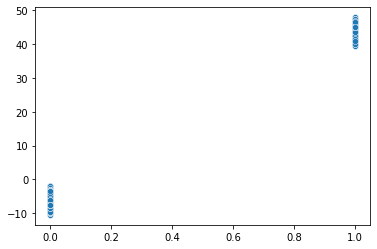

In [10]:
sns.scatterplot(x=manager, y=gshap_values[0])

<AxesSubplot:>

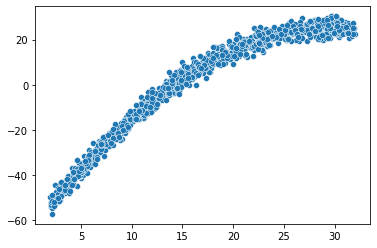

In [11]:
sns.scatterplot(x=social, y=gshap_values[1])

In [12]:
g = lambda y_pred: r2_score(y, y_pred)
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)
gshap_values /= gshap_values.sum()
print('Importance of manager: {:.2f}'.format(gshap_values[0]))
print('Importance of social: {:.2f}'.format(gshap_values[1]))

Importance of manager: 0.32
Importance of social: 0.68


In [159]:
class BaselineRegression(LinearRegression):
    def fit(self, X, y):
        self.y_mean = y.mean()
        
    def predict(self, X):
        return self.y_mean * np.ones(X.shape[0])
    
N_control = N_treat = 175
N = N_control + N_treat
X = np.append(np.ones(N_control), np.zeros(N_treat))
y = .3 * X + norm(0, 1).rvs(N)
cross_val_score(BaselineRegression(), X, y).mean()

-0.05250855703231485

In [185]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.utils import resample
from scipy.stats import expon

class TreatmentRegression(Ridge):
    def __init__(
            self, alpha=0, fit_intercept=False, normalize=False, copy_X=True, 
            max_iter=None, tol=0.001, solver='auto', random_state=None
        ):
        super().__init__(
            alpha,
            fit_intercept=fit_intercept, 
            normalize=normalize, 
            copy_X=copy_X,
            max_iter=max_iter,
            tol=tol,
            solver=solver,
            random_state=random_state
        )
        
    def fit(self, X, y, *args, **kwargs):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1) 
        self.scaler = StandardScaler().fit(X)
        X = self.scaler.transform(X)
        self.y_mean, self.y_std = y.mean(), y.std()
        y = (y - self.y_mean) / self.y_std
        return super().fit(X, y, *args, **kwargs)
        
    def predict(self, X, *args, **kwargs):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        X = self.scaler.transform(X)
        y_pred = super().predict(X, *args, **kwargs)
        return y_pred * self.y_std + self.y_mean
    
    def tune(self, X, y, param_distributions={'alpha': expon(0, 2)}, n_iter=2**6, **kwargs):
        reg = RandomizedSearchCV(self, param_distributions, n_iter=n_iter, **kwargs).fit(X, y)
        self.set_params(**reg.best_params_)
        return self.fit(X, y)
    
def ate(reg, X, treat_var=0, control_val=0, treat_val=1):
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    X_control, X_treat = X.copy(), X.copy()
    X_control[:,treat_var] = control_val
    X_treat[:,treat_var] = treat_val
    return (reg.predict(X_treat) - reg.predict(X_control)).mean()

def bootstrap_ate(reg, X, y, treat_var=0, control_val=0, treat_val=1, bootstrap_samples=1000, stratify=None):
    def sample_ate():
        X_sample, y_sample = resample(X, y, stratify=stratify)
        reg.fit(X_sample, y_sample)
        return ate(reg, X_sample, treat_var, control_val, treat_val)

    return np.array([sample_ate() for _ in range(bootstrap_samples)])

print(cross_val_score(TreatmentRegression(), X, y).mean())
reg = TreatmentRegression().fit(X, y)
print(ate(reg, X))

-0.012630989793629088
0.3989779929919898


In [186]:
ate_sample = bootstrap_ate(reg, X, y)
print(ate_sample.mean(), ate_sample.std())
print(np.quantile(ate_sample, .025), np.quantile(ate_sample, .975))

0.39990732859623584 0.11433562052198577
0.18153376024646617 0.6380722002618981


In [187]:
reg = TreatmentRegression().tune(X, y)
print('tuned alpha', reg.alpha)
print(cross_val_score(reg, X, y).mean())
reg = reg.fit(X, y)
print(ate(reg, X))

tuned alpha 10.106808905054056
-0.011210336074672079
0.3859747495394199


In [188]:
ate_sample = bootstrap_ate(reg, X, y)
print(ate_sample.mean(), ate_sample.std())
print(np.quantile(ate_sample, .025), np.quantile(ate_sample, .975))

0.38484908168385673 0.11100959436206628
0.15877347446510567 0.5973213238144066


In [223]:
df = pd.read_csv('data/pennycook_et_al_study2_raw.csv')
df.head()

,Condition,Fake,Real,Discern,CRT_ACC,SciKnow,MMS,ResponseID,ResponseSet,Name,...,site_gdp_30,min_dist_15,site_pop_15,site_gdp_15,min_dist_10,site_pop_10,site_gdp_10,min_dist_1,site_pop_1,site_gdp_1
0,2,5.133333,5.333333,0.200000,0.000000,0.588235,4.7,R_3J34Pa60coQnKDu,Default Response Set,Anonymous,...,13056917.0,325.565640,230163.0,11564651.0,325.565640,381951.0,17471690.0,74.903283,76351.0,2460726.0
1,1,2.266667,2.933333,0.666667,0.333333,0.588235,5.3,R_2s6gfRcfu9jRhK0,Default Response Set,Anonymous,...,303694235.0,331.814277,2233163.0,303694235.0,331.814277,2233163.0,303694235.0,161.218613,97331.0,5790087.0
2,1,1.000000,1.000000,0.000000,0.000000,0.352941,4.5,R_3jTm56ryzVTu3Ic,Default Response Set,Anonymous,...,1101987.0,1330.622598,128206.0,8114344.0,9.413242,230163.0,11564651.0,9.413242,716492.0,77455208.0
3,1,1.000000,1.000000,0.000000,0.333333,0.764706,2.5,R_1P0Oso567HTKLNE,Default Response Set,Anonymous,...,1101987.0,339.175390,128206.0,8114344.0,31.783372,191659.0,10014469.0,31.783372,2231647.0,122423873.0
4,1,4.933333,4.733333,-0.200000,0.000000,0.529412,5.2,R_1isxtrw6MT71zyt,Default Response Set,Anonymous,...,1101987.0,1284.563436,230163.0,11564651.0,702.437648,44527.0,1940909.0,11.045990,2637772.0,264438886.0


In [224]:
def col_startswith(startswith):
    return [col for col in df.columns if col.startswith(startswith)]

df = df.rename(columns={
    'COVID_concern_1': 'COVID_concern',
    'DemRep_C': 'Partisan',
    'Age.0': 'Age',
    'Education_1': 'Education'
})
df['Treatment'] = df.Condition == 2
df['COVID_news'].iloc[df.COVID_news==7] = 5
df['CRT1_1'] = df.CRT1_1 == 4
df['CRT1_2'] = df.CRT1_2 == 10
df['CRT1_3'] = df.CRT1_3 == 39
df['CRT3_1'] = df.CRT3_1 == 2
df['CRT3_2'] = df.CRT3_2 == 8
# CRT3_3 appears miscoded
# df['CRT3_3'] = df.CRT3_3.str.lower().strip() == 'emily'
df['CRT_chk'] = df.CRT_chk == 1
df['Party'] = df.Party.map({
    1: 'Democrat',
    2: 'Republican',
    3: 'Independent',
    4: 'Other'
})
df['Male'] = df['Gender.0'] == 1
df = df[
    col_startswith('SharingType')
    + col_startswith('SocialMedia')
    + col_startswith('CRT')
    + col_startswith('sci')
    + col_startswith('mms')
    + col_startswith('Media')
    + col_startswith('Ethnicity')
    + col_startswith('Fake')
    + col_startswith('Real')
    + [
        'COVID_concern',
        'COVID_news',
        'AccImp',
        'Age',
        'Male',
        'Education',
        'Income',
        'English',
        'Party',
        'Partisan',
        'Social_Conserv',
        'Economic_Conserv',
        'POTUS2016',
        'Treatment'
    ]
]
df = df.drop(columns=['CRT3_3'])
df = pd.get_dummies(df, columns=['Party'])
df.head()

/home/dsbowen/individual-diff/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,SharingType_1,SharingType_2,SharingType_3,SharingType_4,SharingType_6,SharingType_7,SharingType_7_TEXT,SocialMedia_1,SocialMedia_2,SocialMedia_3,...,English,Partisan,Social_Conserv,Economic_Conserv,POTUS2016,Treatment,Party_Democrat,Party_Independent,Party_Other,Party_Republican
0,1.0,1.0,1.0,1.0,1.0,NaN,,1.0,1.0,1.0,...,1,3.0,1,2,1.0,True,1,0,0,0
1,1.0,NaN,1.0,NaN,NaN,NaN,,1.0,1.0,NaN,...,1,5.0,4,4,2.0,False,0,0,0,1
2,NaN,1.0,NaN,NaN,NaN,NaN,,1.0,NaN,NaN,...,1,3.0,2,2,1.0,False,0,1,0,0
3,NaN,1.0,NaN,NaN,NaN,NaN,,1.0,NaN,NaN,...,1,2.0,4,4,1.0,False,1,0,0,0
4,1.0,1.0,1.0,NaN,1.0,NaN,,1.0,1.0,1.0,...,1,1.0,5,5,1.0,False,1,0,0,0


In [225]:
df = df.drop(columns=(
    col_startswith('CRT_ACC')
    + col_startswith('Real1_RT')
    + col_startswith('Fake1_RT')
    + [
        'SharingType_7_TEXT',
        'SocialMedia_6_TEXT',
        'CRT_Inst',
        'CRT_Rand',
        'CRT_Thomson',
        'Ethnicity_6_TEXT',
        'Real',
        'Fake'
    ]
))

In [226]:
df = df.dropna(subset=[
    col for col in df.columns 
    if col.startswith('Real') or col.startswith('Fake')
])
df['Real'] = df[[col for col in df.columns if col.startswith('Real')]].sum(axis=1)
df['Fake'] = df[[col for col in df.columns if col.startswith('Fake')]].sum(axis=1)
df = df.drop(columns=[
    col for col in df.columns
    if col.startswith('Real1') or col.startswith('Fake1')
])

In [227]:
df['Diff'] = (df['Real'] - df['Fake']) / 15
df.groupby('Treatment').Diff.describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
False,415.0,0.093815,0.729371,-1.866667,-0.266667,0.000000,0.333333,3.266667
True,420.0,0.273175,0.829175,-1.600000,-0.200000,0.066667,0.600000,3.600000


In [ ]:
import seaborn as sns

sns.histplot(x='Diff', hue='Treatment', data=df)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X, y = df.drop(columns=['Real', 'Fake', 'Diff']), df.Diff
X = IterativeImputer().fit_transform(X)
treat = df.Treatment.astype(int).values.reshape(-1, 1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

cross_val_score(LinearRegression(), treat, y).mean()

In [ ]:
const = np.ones((len(df),1))
cross_val_score(LinearRegression(), const, y).mean()

In [ ]:
cross_val_score(LinearRegression(), X, y).mean()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from scipy.stats import expon, uniform

params = {
    'alpha': expon(0, 1),
    'l1_ratio': uniform(0, 1)
}
reg = RandomizedSearchCV(ElasticNet(normalize=True), params, n_iter=2**6).fit(treat, y)
reg.best_score_

In [ ]:
reg = RandomizedSearchCV(ElasticNet(normalize=True), params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.linear_model import Lasso

params = {'alpha': expon(0, 1)}
reg = RandomizedSearchCV(Lasso(normalize=True), params, n_iter=2**6).fit(treat, y)
reg.best_score_

In [ ]:
reg = RandomizedSearchCV(Lasso(normalize=True), params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.linear_model import Ridge

params = {'alpha': expon(0, 1)}
reg = RandomizedSearchCV(Ridge(normalize=True), params, n_iter=2**6).fit(treat, y)
print(reg.best_estimator_.coef_)
reg.best_score_

In [ ]:
reg = RandomizedSearchCV(Ridge(normalize=True), params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

params = {
    'pca__n_components': list(range(2, 50)),
    'ridge__alpha': expon(0, 1)
}
pipeline = make_pipeline(PolynomialFeatures(2), PCA(), Ridge(normalize=True))
reg = RandomizedSearchCV(pipeline, params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from xgboost import XGBRegressor

params = {
    'pca__n_components': list(range(2, 50))
    'xgbregressor__gamma': expon(0, 1),
    'xgbregressor__max_depth': list(range(10)),
    'xgbregressor__min_child_weight': expon(0, 1),
    'xgbregressor__max_delta_step': expon(0, 1),
    'xgbregressor__lambda': expon(0, 1),
    'xgbregressor__alpha': expon(0, 1),
}
reg = RandomizedSearchCV(XGBRegressor(), params, n_iter=10).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score

params = {
    'pca__n_components': list(range(2, 50)),
    'xgbregressor__gamma': expon(0, 1),
    'xgbregressor__max_depth': list(range(10)),
    'xgbregressor__min_child_weight': expon(0, 1),
    'xgbregressor__max_delta_step': expon(0, 1),
    'xgbregressor__lambda': expon(0, 1),
    'xgbregressor__alpha': expon(0, 1),
}
pipeline = make_pipeline(PolynomialFeatures(2), PCA(), XGBRegressor())
reg = RandomizedSearchCV(pipeline, params, n_iter=10).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

params = {
    'pca__n_components': list(range(2, 50)),
    'randomforestregressor__n_estimators': list(range(3, 100)),
    'randomforestregressor__max_depth': list(range(2, 10))
}
pipeline = make_pipeline(PolynomialFeatures(2), PCA(), StandardScaler(), RandomForestRegressor())
reg = RandomizedSearchCV(pipeline, params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.svm import SVR

params = {
    'pca__n_components': list(range(2, 50)),
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__degree': list(range(2, 5)),
    'svr__gamma': ['scale', 'auto'],
    'svr__C': expon(0, 1)
}
pipeline = make_pipeline(PolynomialFeatures(2), PCA(), StandardScaler(), SVR())
reg = RandomizedSearchCV(pipeline, params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.kernel_ridge import KernelRidge

params = {
    'pca__n_components': list(range(2, 50)),
    'kernelridge__alpha': expon(0, 1),
    'kernelridge__kernel': ['linear', 'chi2', 'poly', 'rbf', 'sigmoid'],
}
pipeline = make_pipeline(PolynomialFeatures(2), PCA(), StandardScaler(), KernelRidge())
reg = RandomizedSearchCV(pipeline, params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

params = {
    'pca__n_components': list(range(2, 50))
}
pipeline = make_pipeline(PCA(), StandardScaler(), GaussianProcessRegressor())
reg = RandomizedSearchCV(pipeline, params, n_iter=10).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.tree import DecisionTreeRegressor

params = {
    'pca__n_components': list(range(2, 50)),
    'decisiontreeregressor__max_depth': list(range(2, 10))
}
pipeline = make_pipeline(PCA(), StandardScaler(), DecisionTreeRegressor())
reg = RandomizedSearchCV(pipeline, params, n_iter=10).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

params = {
    'pca__n_components': list(range(2, 50)),
    'adaboostregressor__n_estimators': list(range(2, 100)),
    'adaboostregressor__learning_rate': expon(0, 1),
}
pipeline = make_pipeline(PCA(), StandardScaler(), AdaBoostRegressor())
reg = RandomizedSearchCV(pipeline, params, n_iter=2**6).fit(X, y)
reg.best_score_

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

params = {
    'polynomialfeatures__degree': [1, 2],
    'pca__n_components': list(range(10, 50)),
    'votingregressor__ridge__alpha': expon(0, 1),
    'votingregressor__svr__C': expon(0, 1),
    'votingregressor__svr__degree': list(range(2, 5)),
    'votingregressor__svr__epsilon': expon(0, 0.1),
    'votingregressor__svr__gamma': ['auto', 'scale'],
    'votingregressor__svr__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'votingregressor__ada__n_estimators': list(range(2, 100)),
    'votingregressor__ada__learning_rate': expon(0, 1),
    'votingregressor__kernelridge__alpha': expon(0, 1),
    'votingregressor__kernelridge__kernel': ['rbf'],
    'votingregressor__randomforestregressor__n_estimators': list(range(3, 100)),
    'votingregressor__randomforestregressor__max_depth': list(range(2, 10))
}
pipeline = make_pipeline(
    PolynomialFeatures(),
    PCA(),
    StandardScaler(),
    VotingRegressor(
        [
            ('ridge', Ridge(normalize=True)),
            ('svr', SVR()),
            ('ada', AdaBoostRegressor()),
            ('kernelridge', KernelRidge()),
            ('randomforestregressor', RandomForestRegressor())
        ],
        weights=[2**-i for i in range(5)]
    )
)
reg = RandomizedSearchCV(pipeline, params, n_iter=2**4).fit(X, y)
reg.best_score_

In [ ]:
reg.best_params_

In [ ]:
tmp_df = df.drop(columns=['Real', 'Fake', 'Diff'])
treat_idx = list(tmp_df.columns).index('Treatment')
X[:,treat_idx].mean()

In [ ]:
X_control, X_treat = X.copy(), X.copy()
X_control[:,treat_idx], X_treat[:,treat_idx] = 0, 1
(reg.predict(X_treat) - reg.predict(X_control)).mean()

In [ ]:
effect = reg.predict(X_treat) - reg.predict(X_control)
effect.mean(), effect.std()

In [ ]:
import gshap
from sklearn.metrics import r2_score

class EffectComputer():
    def __init__(self, reg, treat_idx, control=0, treat=1):
        self.reg = reg
        self.treat_idx = treat_idx
        self.control, self.treat = control, treat
        
    def __call__(self, X):
        X_control, X_treat = X.copy(), X.copy()
        X_control[:,self.treat_idx] = self.control
        X_treat[:,self.treat_idx] = self.treat
        return self.reg.predict(X_treat) - self.reg.predict(X_control)

g = lambda effect_pred: r2_score(effect, effect_pred)
model = EffectComputer(reg, treat_idx)
explainer = gshap.KernelExplainer(model, X, g)
gshap_values = explainer.gshap_values(X, nsamples=10)

In [ ]:
gshap_values.sum()

In [ ]:
import gshap
from sklearn.metrics import r2_score

g = lambda y_pred: r2_score(y, y_pred)
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)

In [ ]:
gshap_values /= gshap_values.sum()

In [ ]:
gshap_values[treat_idx]

In [ ]:
crt_cols = [idx for idx, col in enumerate(tmp_df.columns) if col.startswith('CRT')]
gshap_values[crt_cols].sum()

In [ ]:
sci_cols = [idx for idx, col in enumerate(tmp_df.columns) if col.startswith('sci')]
gshap_values[sci_cols].sum()

In [ ]:
mms_cols = [idx for idx, col in enumerate(tmp_df.columns) if col.startswith('mms')]
gshap_values[mms_cols].sum()

In [ ]:
cols = [idx for idx, col in enumerate(tmp_df.columns) 
        if col.startswith('SharingType') or col.startswith('SocialMedia')]
gshap_values[cols].sum()

In [ ]:
cols = [idx for idx, col in enumerate(tmp_df.columns)
       if col.startswith('Media')]
gshap_values[cols].sum()

In [ ]:
cols = [idx for idx, col in enumerate(tmp_df.columns)
       if col.startswith('Ethnicity')]
gshap_values[cols].sum()

In [ ]:
gshap_values[list(tmp_df.columns).index('Age')]

In [ ]:
gshap_values[list(tmp_df.columns).index('Education')]

In [ ]:
gshap_values[list(tmp_df.columns).index('English')]

In [ ]:
gshap_values[list(tmp_df.columns).index('COVID_news')]

In [ ]:
gshap_values[list(tmp_df.columns).index('COVID_concern')]

In [ ]:
gshap_values[list(tmp_df.columns).index('AccImp')]

In [ ]:
cols = [idx for idx, col in enumerate(tmp_df.columns)
       if col in ('Partisan', 'Social_Conserv', 'Economic_Conserv', 'POTUS2016')
       or col.startswith('Party')]
gshap_values[cols].sum()

In [ ]:
gshap_values[list(tmp_df.columns).index('Partisan')]

In [ ]:
gshap_values[list(tmp_df.columns).index('Social_Conserv')]

In [ ]:
gshap_values[list(tmp_df.columns).index('Economic_Conserv')]

In [ ]:
gshap_values[list(tmp_df.columns).index('POTUS2016')]

In [ ]:
cols = [idx for idx, col in enumerate(tmp_df.columns)
       if col.startswith('Party')]
gshap_values[cols].sum()

In [ ]:
cross_val_score(LinearRegression(), treat, y).mean()

In [ ]:
import statsmodels.api as sm

X, y = df.drop(columns=['Real', 'Fake', 'Diff']), df.Diff
X = IterativeImputer().fit_transform(X)
res = sm.OLS(treat, y).fit()
res.summary()

In [ ]:
# TODO standardize y, tough to interpret otherwise

# misidentifying important variables
    # education example
# misinterpreting correlations
    # so why is education correlated with sharing COVID-19 misinformation?
# missing moderators

from scipy.stats import gamma, uniform

educ = uniform(10, 16).rvs(1000)
age = gamma(2.3, 16, 8).rvs(1000)
X = np.array([np.ones(1000), educ, age, age**2]).T
y = X @ np.array([10000, 1000, 1000, -1])
X = np.array([educ, age]).T

class Model(LinearRegression):
    def fit(self, X, y):
        return super().fit(self._transform(X), y)
        
    def predict(self, X):
        return super().predict(self._transform(X))
        
    def _transform(self, X):
        X = np.append(X, (X[:,1]**2).reshape(-1, 1), axis=1)
        return StandardScaler().fit_transform(X)
       
model = Model().fit(X, y)
model.coef_

In [ ]:
g = lambda y_pred: r2_score(y, y_pred)
explainer = gshap.KernelExplainer(model.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=1000)
gshap_values /= gshap_values.sum()
gshap_values

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y)

In [ ]:
# The coefficients in predictive linear models are uninterpretable
# if we found another observation which was identical to x except for x^j, its predicted y value would be this much different from the predicted y value of x